# Linear Regression

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [3]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
from rezaware.modules.etl.loader import sparkFile as file

''' restart initiate classes '''
if debug:
    import importlib
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load data

In [4]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
        file_name="complete-60-accounts.csv",  # optional - name of the file to read
        file_type=None,  # optional - read all the files of same type
        **options,
)
print("Loaded %d rows" % sdf.count())
sdf.printSchema()

25/02/14 11:46:49 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/14 11:46:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/14 11:46:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/14 11:46:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
                                                                                

Loaded 61513 rows
root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- ROAS: double (nullable = true)
 |-- social_spend: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- auction_bid: integer (nullable = true)
 |-- goal: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- purchase: double (nullable = true)
 |-- fb_pixel_view_value: double (nullable = true)
 |-- fb_pixel_purchase_value: double (nullable = true)
 |-- fb_pixel_add_to_cart_value: double (nullable = true)
 |-- mobile_app_purc

## Filter data into Inputs and Outputs


In [5]:
    # 'spend','omni_view_content_value', 'omni_add_to_cart_value',
    # 'omni_initiated_checkout_value', 'omni_purchase_value').dropna().collect())

_data_df= sdf.select('spend','CTR', 'CPC', 'CPM', 'ROAS').dropna().toPandas()
print("data shape:", _data_df.shape)
print("data mean :", _data_df.mean())
print("data std  :", _data_df.std())
print("data max  :", _data_df.max())

data shape: (26193, 5)
data mean : spend    972.451701
CTR        3.682901
CPC        5.260815
CPM      108.559637
ROAS       8.339972
dtype: float64
data std  : spend    1701.870868
CTR         3.735689
CPC         7.055442
CPM       113.554289
ROAS      269.040776
dtype: float64
data max  : spend    25292.870000
CTR         50.000000
CPC        262.570000
CPM       3668.377193
ROAS     40040.000000
dtype: float64


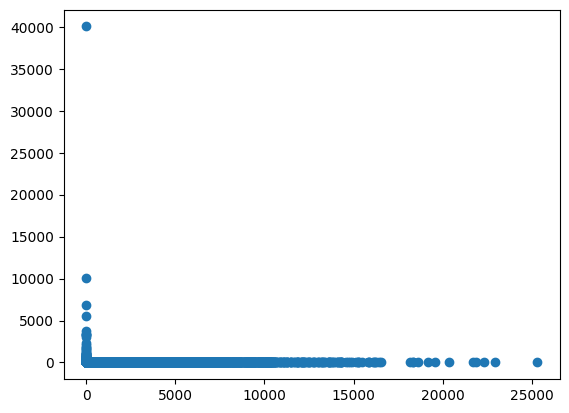

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(_data_df['spend'],_data_df['ROAS'])

## Define the model

* [Probabilistic Modeling with TensorFlow Probability](https://www.scaler.com/topics/tensorflow/tensorflow-probability/)
* [Tensorflow probability examples](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/examples/jupyter_notebooks)

## Split the train & test data

In [7]:
# Compile and train the standard neural network
_pred_cols = ['CPC'] #, 'CPM', 'ROAS', 'CTR']
_label_col = ['spend']
X = np.array(_data_df[_pred_cols])
y = np.array(_data_df[_label_col])             
print("X: ",X.shape,"y: ", y.shape)

X:  (26193, 1) y:  (26193, 1)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print("X_train: ",X_train.shape, "y_train: ", y_train.shape,
      "\nX_test: ", X_test.shape, "y_test: ", y_test.shape)

X_train:  (20954, 1) y_train:  (20954, 1) 
X_test:  (5239, 1) y_test:  (5239, 1)


## Simple Linear Regression model

In [9]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [10]:
clf.predict(X_test)

array([[ 893.12050129],
       [ 910.88733388],
       [1177.83055026],
       ...,
       [1112.57344806],
       [1283.4515804 ],
       [ 870.86858033]])

In [11]:
clf.score(X_test, y_test)

0.018000433492830314